  # One-shot Leaning Challenge
  
  In this notebook I will present an analysis of the challenge and a proposed selution. 
  My path towards this solution concise of these steps:
  1) Reading literature\blog posts\etc. ralated to the data set, some proposed solutions and particularly on the meta-learning algorithm I will use MAML. 
  2) Practicaly playing with the data, understanding the input and ways to augment it if needed. 
  3) Writing Psaudo-code for the model architecture
  4) Desciding on the aproprate processing and comparing methods
  5) Writing all the helper functions for the MAML model
  6) Building it all together
  

# One-shot 20-way peoblem statement:
"One-shot classification was evaluated through
a series of within-alphabet classification tasks for
10 different alphabets. As illustrated in Fig. 1B, i,
a single image of a new character was presented,
and participants selected another example of that
same character from a set of 20 distinct characters
produced by a typical drawer of that alphabet."
The data set will be constructed to test this model. Batches build from a train set of one alphabet (x_i) and its classification, followed by 19 randomly chosen alphabets (which are not x) plus a different representation of x (x_j where i not = j). 
I follow the experimental protocol proposed by Vinyals et al. (2016), "The N-way Omniglot task setup is as follows: pick N unseen character classes, independent of alphabet, as L. Provide the model with one drawing of each of the N characters as S ~ L and a batch B ~ L."




In [150]:
import numpy as np
import pandas as pd
from skimage.transform import rescale, resize, downscale_local_mean
from collections import OrderedDict

import imageio
import random
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from scipy.misc import imread
import random

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.optim as optim



In [148]:
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [133]:
#Loads images
data_path = "Documents\challenge\Omniglot"
train_path = os.path.join(data_path, 'images_background')
eval_path = os.path.join(data_path, 'images_evaluation')

def load_images(path):
    '''
    
    Input: path of the folders where the data sets are stored
    
    Return:
    X = A list of the images extracted from the data sets folders, the size list matrix will be: 
    (number of letters in the eval/training set) X (number of examples of each letter) X (pixel width) X (pixel height)
    
    indexed_alphabets = holds the names and letters number in a seperate list
    
    '''
    X = []
    
    indexed_alphabets = [] # to hold the name of the alphabet and character number
    
    # Going over the alphabets
    for alphabet in os.listdir(path) :
        #print ("loading alphabet: " + alphabet)
        alphabet_path = os.path.join(path, alphabet)
        
        #Going over the letters in the same category 
        
        for letter in os.listdir(alphabet_path):
                catagory_images = []
                letter_path = os.path.join(alphabet_path, letter)
                
                if not os.path.isdir(letter_path):
                    continue
                
                # Going over the examples
                for example in os.listdir(letter_path):
                    image_path = os.path.join(letter_path,example)
                    image = imageio.imread(image_path)
                        
                    ## normalize the images
                    image = (image - image.mean()) / image.std()
                    
                        
                    catagory_images.append(image)
                        
                try:
                    X.append(np.stack(catagory_images))
                    indexed_alphabets.append([alphabet, letter])
                except ValueError as e:
                    print(e)
                    print("error - category_images:", catagory_images)
                    
    
    return X, indexed_alphabets





In [213]:
train_set, train_index = load_images(train_path)
eval_set, eval_index = load_images(eval_path)


In [199]:
print("train_set shape is: ", np.shape(train_set))
print("train_index shape is: ", np.shape(train_index))
print("eval_set shape is: ", np.shape(eval_set))
print("eval_index shape is: ", np.shape(eval_index))
print("Each image is of size: ", np.shape(train_set)[2], "X" , np.shape(train_set)[3] )



train_set shape is:  (964, 20, 105, 105)
train_index shape is:  (964, 2)
eval_set shape is:  (659, 20, 105, 105)
eval_index shape is:  (659, 2)
Each image is of size:  105 X 105


torch.Size([105, 105])


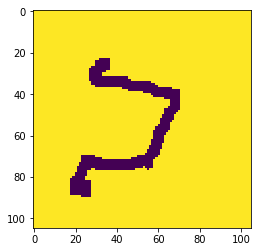

In [129]:
print(np.shape(train_set[9][9]))

plt.imshow(train_set[9][9])
#A = torch.from_numpy(train_set[9][9])
#print(type(A))

Images of random charecters from the data set


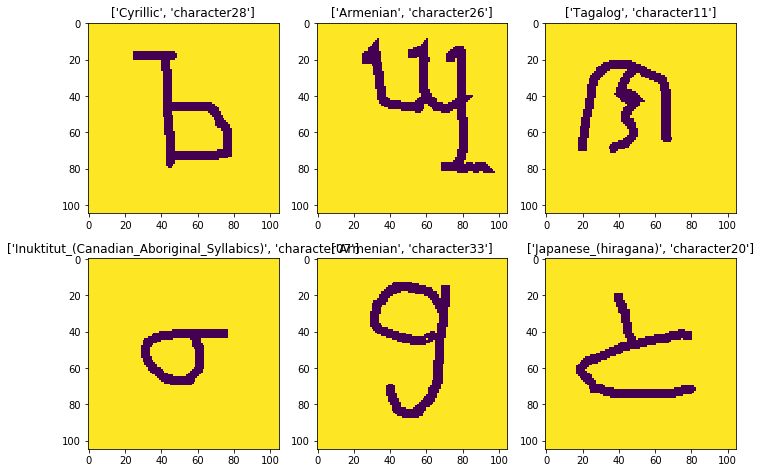

In [112]:
# Lets see random images of latters 
plt.subplots_adjust(left=5, bottom=5, right=6.5, top=6.5, wspace=None, hspace=None)
for i in range(1, 7):
    ax = plt.subplot(2, 3, i )
    t = random.randrange(np.shape(train_set)[0])
    r = random.randrange(20)
    ax.set_title(train_index[t])
    plt.imshow(train_set[t][r])
print("Images of random charecters from the data set")

Images of different charecters of the same alphabet


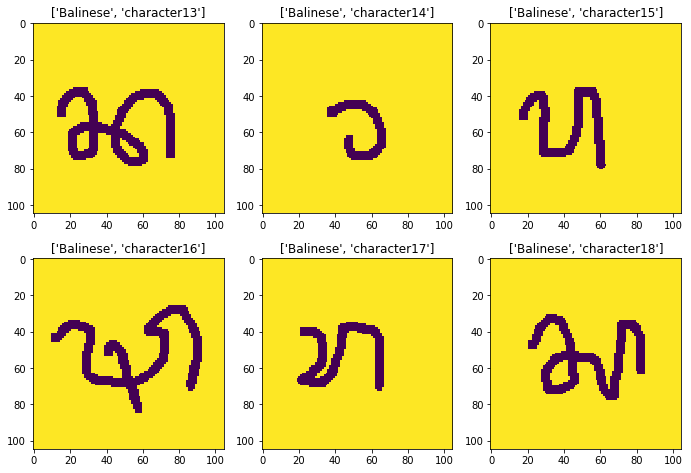

In [113]:
# Lets see images of different charecters from the same alphabet  
plt.subplots_adjust(left=5, bottom=5, right=6.5, top=6.5, wspace=None, hspace=None)
t = 167
for i in range(1, 7):
    ax = plt.subplot(2, 3, i ) 
    r = 1
    ax.set_title(train_index[t+i])
    plt.imshow(train_set[t+i][r])
print("Images of different charecters of the same alphabet")

Images of different examples of the same charecter


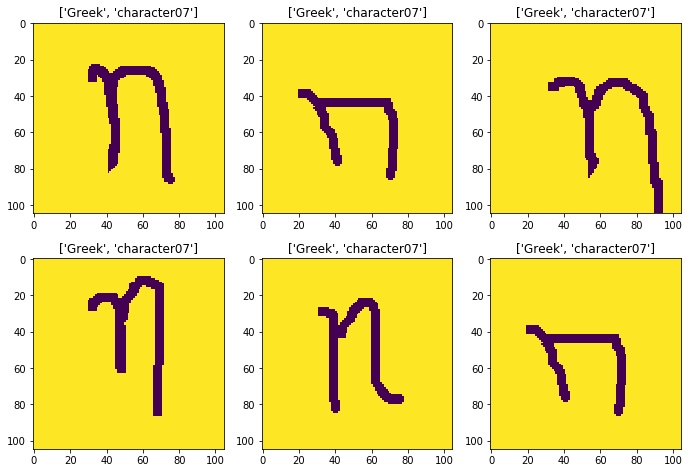

In [114]:
# Lets see images of different examples of same charecter  
plt.subplots_adjust(left=5, bottom=5, right=6.5, top=6.5, wspace=None, hspace=None)
t = random.randrange(np.shape(train_set)[0])
for i in range(1, 7):
    ax = plt.subplot(2, 3, i ) 
    r = random.randrange(20)
    ax.set_title(train_index[t])
    plt.imshow(train_set[t][r])
print("Images of different examples of the same charecter")

# The data set - 

* muiltiple examples of 1623 handwritten charecters from 50 alphabets in grayscale.
* All images are 105X105 in size
* Both images and pen strokes were collected
In the MAML paper and in other meta-learning sources, while working on the few-shot classification challenge they used only the images and neglected the pan strokes (unlike the original paper which did include it in the training phase), I belive that incorporating the pan stokes could prove to be usefull as some writen languages have distinct writen patterns. For example Hebrew and Arabic are writen from right to left, Sanskrit latter are finished with a line above them at the end of the stroke, these charectristicts would be distinct in the pan stroke. Due to lack of time I did not put this to the test, but it could be a good foloup on this challenge.

From going over a few sets of examples I understend the following:
* Some alphabets have distinct charectaristics such as straight lines (as in Sanskrit), dots (as in Arcadian), distinct wigle marks (as in the Balinese). All of these can help group charecters from same alphabe. 
* On the other hand, in between most alphabets I did not enquanter a rebust difference that so on a second look I could guess that this is X rather then Y. With this being said, due to high perfomrance of inter alphabet one-shot learning algorithms comperint to intra alphabet algorithms it is safe to say that there are distinct differneces between alphabets. 
* Most letters are centered in the middle of the image.
* Data augmentation seems natural for this challenge for it increses the data set and could be internal to the model, i.e. as part of handeling the images while given a spasific batch or task. A few options are - rotating, adding random noise, scale, moving the letter left or right and many more to increase our data set size. 
* As there not many details and background in the images downsampaling to resize the image seems like a good option to increase speed without risking the data. 



Rescaled image size -  (28, 28)
Original image size -  (105, 105)


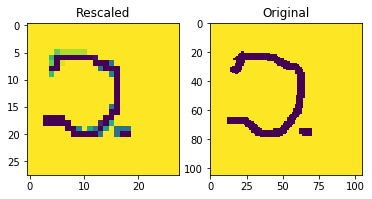

In [115]:
image_rescaled = rescale(train_set[5][5], 1.0 / 3.8, anti_aliasing=False, mode='constant')
ax = plt.subplot(1, 2, 1)
ax.set_title("Rescaled")
print("Rescaled image size - ", np.shape(image_rescaled))
print("Original image size - ", np.shape(train_set[5][5]))
plt.imshow(image_rescaled)
ax = plt.subplot(1, 2, 2 )
ax.set_title("Original")
plt.imshow(train_set[5][5])

# Model Agnostic Meta-Learning (MAML)
I chose this model for its good results in this challenge (4.2% which is among the best using meta-learning) and due to its simplicity and versatility of being model agnostic. It is a meta-algorithm compatible for a varaity systems using gradient descent procedure, this makes it a powerful tool to have and a better way to interact between codes and coders. Add about simplivcity of the concept and about using fewer parameters.
Add about relevent to the research
"The key idea underlying our method is to train the model’s
initial parameters such that the model has maximal performance
on a new task after the parameters have been updated
through one or more gradient steps computed with
a small amount of data from that new task."
"In effect, the meta-learning problem treats entire tasks as training examples." Meaning, solving the spacific task at hand is only a step to update the meta-parametrs. 
For simplicity of this challange alpha and beta will be constant. 
"Because the method uses gradient descent as the
optimizer, it does not introduce any additional parameters, making it more parameter-efficient than
other meta-learning methods." 

# Model Architecture FOMAML:
Difine alpha and beta hyperparameters 
Orgenize data into tasks, trainings and eavaluation sets.
randomly initialize meta-parameters - theta
While training:
    initialize tesk batch - choose X tasks of 20 i.i.d characters (one example of each). I chose batch size X = 18, so the meta
    parameters are updated using gradiants from 18 tasks at a time.  
    Clone meta-parameters 
    For each task in batch: 
        Divide the batch to:
        S - support set for learning - 1 example for each of the 20 charecters chosen. 
        B - prediction set, training/testing. For evaluation, same size as S.
        For epoch in number of epochs: #epoch size should be small to evoid overfitting, I will use 5. 
            if epoch is 0:
            theta' = cloned meta-parameters  #create a copy of the meta-parameters for learning.
            else:
            continue
            S is fed into a ConvNet-softmax learner
            Get loss using cross entropy loss function
            train the net parameters theta' using update rule (remember the for the first epoch theta'=thata)
            theta' = theta' - alpha * grad (loss) 
        Use B set for the meta-update - 
        Calculate loss and gradiants for the new data points. (one epoch)
        Add these gradiants as the meta-parameters update 
     Update meta-parameters using the gradiants from the last batch and update rule for first order MAML: theta = theta - 
     beta * sum(B gradiant updates sumed over X tasks)
end

While evaluating:
    for each task in evaluation set:
        theta' = theta
        for epoch in number of epochs = 10:
            train the network using the same network model (ConvNet - softmax)
        After training:
        pick another, unseen exampel of a charecter from the task and run the prediction network on it
        
If time allows, create a siames network implementation. 
        



In [211]:
#Creating a batch for the One-shot classification problem

def create_batch(data_set, n_shot = 1, k_way = 20, batch_size = 1, picked_k_all):
    '''
    Arguments:
    data_set - a set of images from the training or evaluation sets
    n_shot - number of examples from each charecter 1 for this spacific task but could be larger
    k-way - number of charecters in the task
    batch_size = How many task to group in one epoch of the MAML
    
    Return:
    batch - a batch_size list, each place contains three parts:
    1) Tasks matrix, each containing 2*n_shot by k_way images, the matrix is divided to two parts, the first is for learning 
    and the second for training 
    2) y_label, containing true values for training softmax classifier
    3) picked_k - a list of indexes of letter chosen in the task from the data_set, in order to use while evaluating the 
    performence. 
    
    '''
    
    batch = []
    batch = []
    if picked_k_all is None:
        picked_k_all = []
    for b in range(batch_size):
        # initializing task list for the k charecters:
        picked_k = []
        task_learn = []
        task_train = []
        for k in range(k_way):
            #randomly choosing a charecter
            t = random.randrange(np.shape(data_set)[0])
            picked_char = []
            
            #checking that we are not seleceting the same charecter twice
            if not t in picked_k_all:
                
                for n in range(n_shot):
                    #randomly choosing an example
                    r_learn = random.randrange(20)
                    r_train = random.randrange(20)
                    
                    #checking we don't select the same example twice
                    if not r_learn in picked_char:
                        char_rescaled = rescale(train_set[t][r_learn], 1.0 / 3.8, anti_aliasing=False, mode='constant')
                        task_learn.append(char_rescaled)
                        picked_char.append(r_learn)
                    if not r_train in picked_char:
                        char_rescale = rescale(train_set[t][r_train], 1.0 / 3.8, anti_aliasing=False, mode='constant')
                        task_train.append(char_rescaled)
                        picked_char.append(r_train)
                        
            picked_k.append(t)
            picked_k_all.append(t)
            #For each task the y label, true classification, is local to the randomly constructed task
            #Therfore using an identity matrix to construct y labels stacked in a matrix seems natural and simple
            #
            y_label = np.identity(20)
            
        batch.append([task_learn, task_train, y_label, picked_k])
        #create Y as an identity matrix of size 20x20 for the softmax? 
        #add learning or training set so we have for each task learning set and training set. 
    
    return batch, picked_k_all
    
            
            
    

SyntaxError: non-default argument follows default argument (<ipython-input-211-e01831a8d8fe>, line 3)

In [261]:
class OneShotMAML(nn.Module):
    # Defining the ConvNet for the learner
    
    def __init__(self):
        super(OneShotMAML, self).__init__()
        
        # Define the networks steps:
        self.layers = nn.Sequential([
            ('conv1', nn.Conv2d(1, 64, 3, stride = 2)),
            ('batchNorm1', nn.BatchNorm2d(64)),
            ('relu1', nn.ReLU(inplace = True)),
            ('conv2', nn.Conv2d(64, 64, 3, stride = 2)),
            ('batchNorm2', nn.BatchNorm2d(64)),
            ('relu2', nn.ReLU(inplace = True)),
            ('conv3', nn.Conv2d(64, 64, 3, stride = 2)),
            ('batchNorm3', nn.BatchNorm2d(64)),
            ('relu3', nn.ReLU(inplace = True))
        ]))
        self.add_module('fc', nn.Linear(64,20))
    '''
    def BatchNormChangeWeight(input, weight=None, bias=None, running_mean=None, running_var=None, training=True, eps=1e-5, momentum=1):
        #Got some help with this one by looking at https://github.com/katerakelly/pytorch-maml/blob/master/src/layers.py
        #In order to move weights to the new trainer
        running_mean_ = torch.zeros(np.prod(np.array(input.data.size()[1])))
        running_var_ = torch.ones(np.prod(np.array(input.data.size()[1])))
        return F.batch_norm(input, running_mean, running_var, weight, bias, training, momentum, eps)
    '''
    
    def forward(self, x):
            #x = torch.from_numpy(x)
            x = self.layers(x)
            x = x.view(x.size(0), 64)
            x = selc.fc(x)

    

SyntaxError: invalid syntax (<ipython-input-261-8639896ae1d2>, line 18)

In [215]:
A = create_batch(train_set)

In [244]:
task = (((A[0])[0])[0])
train_loader = torch.utils.data.DataLoader(task)
for inputs in train_loader:
    print(type((inputs[0])))


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [256]:
print(type(task))
for t in task:
    #print(t.size())
    t = t.unsqueeze(0)
    t = t.unsqueeze(0)
    
    print(t.type())
for t in task:
    print(t.size())
    

<class 'list'>
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.DoubleTensor
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


In [262]:
#task = ((A[0])[0])[0]
Y = torch.eye(20)
Y = Y.double()

print(Y.type())
loss_func = nn.CrossEntropyLoss()
net = OneShotMAML()
for t in task:
    input_ = t.unsqueeze(0)
    input_ = input_.unsqueeze(0)
    print(input_.type(), input_.size())
    output = net(input_)
    loss = loss_func(output, Y)
    net.zero_grad()
    loss.backwards()

    for name, param in net.named_parameters():
        print(name)

    model_dict = net.state_dict()
    for f in model_dict:
        if f == 'layers.conv1.weight':
            print((model_dict[f])[0])
        if f == 'layers.batchNorm2.weight':
            print((model_dict[f])[1])

    for name, param in net.named_parameters():
        model_dict[name] -= 0.01*param.grad
    with torch.no_grad():
        for param in net.parameters():
            param -= 0.01 * param.grad
    

    for f in model_dict:
        if f == 'layers.conv1.weight':
            print((model_dict[f])[0])
        if f == 'layers.batchNorm2.weight':
            print((model_dict[f])[1])

    model.dict2 = net.state_dict()
    for f in model_dict2:
        if f == 'layers.conv1.weight':
            print((model_dict2[f])[0])
        if f == 'layers.batchNorm2.weight':
            print((model_dict2[f])[1])

torch.DoubleTensor
torch.DoubleTensor torch.Size([1, 1, 28, 28])


RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'weight'

In [204]:
sd=torch.eye(5)
print(sd)

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])


<class 'numpy.ndarray'>


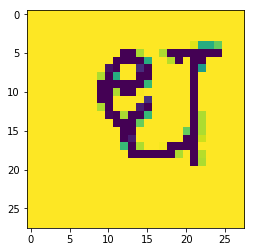

In [106]:
task = ((A[0])[0])[0]
char = task[0]
plt.imshow(char)
print(type(task[0]))


In [ ]:
def meta_step(meta_model, training_batch, num_inner_epochs = 5, inner_learning_rate = 0.1, meta_learning_rate = 0.1, 
              loss_func = 'CrossEntropyLoss' ):
    ''''
    Takes a meta update step for the model.
    
    Arguments:
    meta_model - the meta model, we will use it to create the clone for the fast-learning inner loops.
    training_batch - batch of tasks for the inner learner.
    num_inner_epochs - number of epochs to use in the inner loop of each task.
    inner_learning_rate - the learning rate to be used in the inner loops, set to 0.1 as in the article.
    meta_learning_rate - the learning rate to be use for updating the meta-parameters, set to 0.1 as in the article.
    loss_func - the loss function to use in the inner loops - set to be Cross-entropy 
    
    Return:
    meta_model_dict - the updated meta-parameters 
    
    ''''
    meta_model_dict = meta_model.state_dict() #the update will be on the state_dict() of the meta model and will later update
                                                # the meta_parameters using this dict. 
    meta_gradiant = []
    if loss_func == 'CrossEntropyLoss':
        loss_func = nn.CrossEntropyLoss()
        
    for task in training_batch[0]:
        S = task[0] #The set for learning
        B = task[1] #The set for training
        Y = task[2] #The true y labels
        fast_learner_net = copy.deepcopy(meta_model)
        for epoch in num_inner_epochs:
            for char in range(len(S)):
                output = fast_learner_net(S[char])
                target = Y[char]
                loss = loss_func(output, target)
                fast_learner_net.zero_grad()
                loss.backwards()
                with torch.no_grad():
                    for param in fast_learner_net.parameters():
                        param -= inner_learning_rate * param.grad
                    
        #Computing the grads for the meta-update using the training set B:
        output = fast_learner_net(B)
        target = Y
        loss = loss_func(output, target)
        meta_model.zero_grad()
        loss.backwards()
        grad_list = []
        with torch.no_grad():
            for name, param in fast_learner_net.named_parameters():
                meta_model_dict[name] -= meta_learning_rate * param.gard #the name on the list are the same so we update 
    
    return meta_model_dict                
        
        

In [ ]:
class evaluate_model(meta_model, evaluation_set, batch_size = 4, number_of_examples = 15, num_inner_epochs = 10, 
                   inner_learning_rate = 0.1, 
                   meta_learning_rate = 0.1, loss_func = 'CrossEntropyLoss' ):
    
    ''''
    Evaluate the model using one-shot example tests.
    
    Arguments:
    meta_model - the trained meta model.
    evaluation_set - the set for evaluation.
    batch_size - number of batches from the evaluation set 
    number_of_examples - number of never seen examples to evaluate the trained network.
    num_inner_epochs - number of epochs to use in the inner loop of each task.
    inner_learning_rate - the learning rate to be used in the inner loops, set to 0.1 as in the article.
    meta_learning_rate - the learning rate to be use for updating the meta-parameters, set to 0.1 as in the article.
    loss_func - the loss function to use in the inner loops - set to be  Cross-entropy
    
    Returns:
     right_percentage - How good is our model?  
    
    ''''
    #Creating a batch for the One-shot classification problem

    def create_eval_batch(data_set, n_shot = 1, k_way = 20, batch_size = 1, picked_k_all=None):
        '''
        Arguments:
        data_set - a set of images from the training or evaluation sets
        n_shot - number of examples from each charecter 1 for this spacific task but could be larger
        k-way - number of charecters in the task
        batch_size = How many task to group in one epoch of the MAML
    
        Return:
        batch - a batch_size list, each place contains three parts:
        1) learning set and training set, each containing n_shot by k_way images.
        2) Evaluation set with 15 examples for testing the post trained model.  
        3) y_label, containing true values for training softmax classifier.
        4) picked_k - a list of indexes of letter chosen in the task from the data_set, in order to use while evaluating the 
        performence. 
    
        '''
    
        batch = []
        if picked_k_all is None:
            picked_k_all = []
        for b in range(batch_size):
            # initializing task list for the k charecters:
            picked_k = []
            task_learn = []
            task_train = []
            task_eval = []
            y_eval = []
            for k in range(k_way):
                #randomly choosing a charecter
                t = random.randrange(np.shape(data_set)[0])
                picked_char = []
            
                #checking that we are not seleceting the same charecter twice
                if not t in picked_k_all:
                
                    for n in range(n_shot):
                        #randomly choosing an example
                        r_learn = random.randrange(20)
                        r_train = random.randrange(20)
                    
                        #checking we don't select the same example twice
                        if not r_learn in picked_char:
                            char_rescaled = rescale(train_set[t][r_learn], 1.0 / 3.8, anti_aliasing=False, mode='constant')
                            task_learn.append(char_rescaled)
                            picked_char.append(r_learn)
                        if not r_train in picked_char:
                            char_rescale = rescale(train_set[t][r_train], 1.0 / 3.8, anti_aliasing=False, mode='constant')
                            task_train.append(char_rescaled)
                            picked_char.append(r_train)
                
                picked_k.append(t)
                picked_k_all.append(t)
                #For each task the y label, true classification, is local to the randomly constructed task
                #Therfore using an identity matrix to construct y labels stacked in a matrix seems natural and simple
                #
                y_label = np.identity(20)
            for i in range(15):
                t = random.choice(picked_k)
                r = random.randrange(20)
                char_rescale = rescale(train_set[t][r], 1.0 / 3.8, anti_aliasing=False, mode='constant')
                task_eval.appand(char_rescaeled)
                for i in range(k_way):
                    if picked_k[i] == t:
                        y_eval.append(y_label[i])
                
            batch.append([task_learn, task_train, y_label, task_eval, y_eval, picked_k])
            #create Y as an identity matrix of size 20x20 for the softmax? 
            #add learning or training set so we have for each task learning set and training set. 
    
        return batch
    
    def evaluate(meta_model, eval_batch, num_inner_epochs = 10, inner_learning_rate = 0.1, 
                  loss_func = 'CrossEntropyLoss' ):
        ''''
        Evaluate the model
    
        Arguments:
        meta_model - the trained meta model.
        eval_batch - batch of tasks for the inner learner and evaluation examples.
        num_inner_epochs - number of epochs to use in the inner loop of each task.
        inner_learning_rate - the learning rate to be used in the inner loops, set to 0.1 as in the article.
        loss_func - the loss function to use in the inner loops - set to be Cross-entropy 
    
        Return:
        meta_model_loss - the avarage loss of the model
    
        '''' 
        
        if loss_func == 'CrossEntropyLoss':
            loss_func = nn.CrossEntropyLoss()
        
        right_percentage = []
        
        for task in eval_batch:
            right_ans = 0
            S = task[0] #The set for learning
            B = task[1] #The set for training
            Y = task[2] #The true y labels
            task_eval = task[3] #the 15 evaluation examples
            eval_y = task[4] #the examples y labels
            fast_learner_net = copy.deepcopy(meta_model)
            for epoch in num_inner_epochs:
                for char in range(len(S)):
                    output = fast_learner_net(S[char])
                    target = Y[char]
                    loss = loss_func(output, target)
                    fast_learner_net.zero_grad()
                    loss.backwards()
                    with torch.no_grad():
                        for param in fast_learner_net.parameters():
                            param -= inner_learning_rate * param.grad
                    
            #Computing the grads for the meta-update using the training set B:
            for char in range(len(B)):
                output = fast_learner_net(B[char])
                target = Y[char]
                loss = loss_func(output, target)
                meta_model.zero_grad()
                loss.backwards()
                grad_list = []
                with torch.no_grad():
                    for param in fast_learner_net.parameters():
                         param -= inner_learning_rate * param.gard
            #Now for the predictions:
            for example in range(15):
                output = fast_learner_net(task_eval[example])
                softmax = nn.Softmax()
                prediction = softmax(output)
                target = eval_y[example]
                if target == prediction:
                    right_ans+=1
            right_percentage.append(right_ans/15)
    
        return right_percentage

    return right_percentage
        
            
            
    
    

# Puting it all together:

In [35]:
#Initializing the meta-model:
meta_model = OneShotMAML()
#Running a for loop for the meta-updates:
picked_k_all = []
For count in range(round(964/18)):
    training_batch = create_batch(training_set, n_shot = 1, k_way = 20, batch_size = 18, picked_k_all)
    meta_model_dict = meta_step(meta_model, training_batch, num_inner_epochs = 5, inner_learning_rate = 0.1, meta_learning_rate = 0.1, 
              loss_func = 'CrossEntropyLoss' )
    meta_model.load_state_dict(meta_model_dict)

right_percentage = evaluate_model(meta_model, evaluation_set, batch_size = 32, number_of_examples = 15, num_inner_epochs = 10, 
                   inner_learning_rate = 0.1, 
                   meta_learning_rate = 0.1, loss_func = 'CrossEntropyLoss' )
mean_right = np.mean(right_percentage)
    
    
    
    

[([1, 2, 3], [3, 5, 2]), ([2, 3, 4], [2, 7, 3]), ([3, 4, 5], [6, 4, 8])]
[[1, 2, 3], [2, 3, 4], [3, 4, 5]]
